In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px

from sklearn.cluster import KMeans

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import socket
import struct
import os
import glob

In [2]:
def ip2number(addr):
    return str(struct.unpack("!I", socket.inet_aton(addr))[0])


def int2ip(addr):
    return socket.inet_ntoa(struct.pack("!I", addr))

def add_metadata_columns(df_tmp):
    df = df_tmp.copy()
    
    df["__time"]=(pd.to_datetime(df["__time"],unit='ms')) 
    df['hour'] = df.__time.dt.hour
    
    df = df.join(df.groupby(['hour'])['sum_bytes'].mean(), on='hour', rsuffix='_hourly_mean')
    df = df.join(df.groupby(['hour'])['sum_bytes'].max(), on='hour', rsuffix='_hourly_min')
    df = df.join(df.groupby(['hour'])['sum_bytes'].min(), on='hour', rsuffix='_hourly_max')
    df = df.join(df.groupby(['hour'])['sum_bytes'].std(), on='hour', rsuffix='_hourly_std')
    
    df.drop("sum_bytes", axis=1, inplace=True)
    df.drop("__time", axis=1, inplace=True)
    df.drop("sum_pkts", axis=1, inplace=True)
    return df

def build_df(df_tmp, drop_lan_features=False):
    df = df_tmp.copy()
    
    if drop_lan_features:
        df.drop("lan_ip_country_code", axis=1, inplace=True)
        df.drop("lan_interface_name", axis=1, inplace=True)
        df.drop("lan_ip", axis=1, inplace=True)
        df.drop("lan_ip_as_name", axis=1, inplace=True)
        df.drop("lan_l4_port", axis=1, inplace=True)
        
    df['wan_ip'] = df['wan_ip'].map(ip2number)
    # Vamos a hacer drop de la columna "application_id" porque representa lo mismo que "application_name"
    df.drop("application_id", axis=1, inplace=True)
    total_rows = len(df.index)
    
    for column in df.columns:
        null_sum = df[column].isnull().sum()
        if null_sum != 0:
            null_percentage = null_sum / total_rows  * 100
            if null_percentage >= 50:
                #print(f'Deleted column: {column} ({null_percentage}%)')
                df.drop(column, axis=1, inplace=True)
    for column in df.columns:
        if len(df[column].unique()) == 1:
            df.drop(column, axis=1, inplace=True)
            #print(f'Deleted column because of unique value: {column}')
    
    for column in df.columns:
        if df[column].dtypes == "object":
            df[[column]] = df[[column]].apply(lambda col:pd.Categorical(col).codes)
        
    print(df.columns)
    print(len(df.columns))
        
    return df

def plot_3d(X, C, labels):
    colors=['red','green']#,'blue','cyan','yellow']
    assign=[]
    for row in labels:
        assign.append(colors[row])
 
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)
    ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colors, s=1000)

In [3]:
mainpath="../Sample dataset/"

csv_files = glob.glob(os.path.join(mainpath, "*.csv"))
df = pd.DataFrame()

for f in csv_files:
    df_tmp = pd.read_csv(f)
    df = df.append(df_tmp)

In [4]:
df.head()

,__time,level,application_id,application_name,direction,engine_id,host,host_category,wan_ip_country_code,lan_ip_country_code,...,wan_ip_as_name,wan_l4_port,serial_number,saas_name,saas_family,host_l2,referer_l2,events,sum_bytes,sum_pkts
0,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,teams.events.data.microsoft.com,cleaning,US,CN,...,ATT-INTERNET4,771,848/06464,NaN,NaN,microsoft.com,NaN,1,229,1
1,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,ssl.gstatic.com,liste_blanche,US,US,...,AKAMAI-AS,54606,848/06464,Google portal and shared services,IT & Communication,gstatic.com,NaN,1,509,1
2,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,r2.sn-h5qzen76.googlevideo.com,movies,US,US,...,EDGECAST,60733,848/06464,Youtube,Streaming,googlevideo.com,NaN,1,524,1
3,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,presence.teams.microsoft.com,cleaning,US,US,...,ATGS-MMD-AS,58244,848/06464,NaN,NaN,microsoft.com,NaN,1,540,1
4,1639399860000,23f24570-d2c9-4e6e-a833-3d1734e110c8.abcc9097-...,6:3,PRIVATE ADDRESSING,upstream,6,play.google.com,shopping,US,CN,...,GOOGLE,65504,848/06464,Google Play,Storage,google.com,NaN,1,509,1


In [5]:
df_transformed = add_metadata_columns(build_df(df, drop_lan_features=True))

Index(['__time', 'application_name', 'direction', 'engine_id',
       'wan_ip_country_code', 'l4_proto', 'selector_name', 'tcp_flags', 'tos',
       'wan_interface_name', 'wan_ip', 'wan_ip_as_name', 'wan_l4_port',
       'events', 'sum_bytes', 'sum_pkts'],
      dtype='object')
16


In [59]:
df_transformed.head()

,application_name,direction,engine_id,wan_ip_country_code,l4_proto,selector_name,tcp_flags,tos,wan_interface_name,wan_ip,wan_ip_as_name,wan_l4_port,events,hour,sum_bytes_hourly_mean,sum_bytes_hourly_min,sum_bytes_hourly_max,sum_bytes_hourly_std
0,43,1,6,77,1,4,0,192,1,2865,63,771,1,12,37696.668467,264191903,30,1.219509e+06
1,43,1,6,77,17,4,0,0,1,2883,19,54606,1,12,37696.668467,264191903,30,1.219509e+06
2,43,1,6,77,17,4,0,0,1,2882,255,60733,1,12,37696.668467,264191903,30,1.219509e+06
3,43,1,6,77,17,4,0,0,1,2889,59,58244,1,12,37696.668467,264191903,30,1.219509e+06
4,43,1,6,77,17,4,0,0,1,2896,315,65504,1,12,37696.668467,264191903,30,1.219509e+06


In [10]:
X = np.array(df_transformed)
X.shape

(3336336, 18)

In [7]:
kmeans = KMeans(n_clusters=2).fit(X)

In [8]:
labels = kmeans.predict(X)

In [11]:
labels.shape

(3336336,)

In [13]:
X[0]

array([4.30000000e+01, 1.00000000e+00, 6.00000000e+00, 7.70000000e+01,
       1.00000000e+00, 4.00000000e+00, 0.00000000e+00, 1.92000000e+02,
       1.00000000e+00, 2.86500000e+03, 6.30000000e+01, 7.71000000e+02,
       1.00000000e+00, 1.20000000e+01, 3.76966685e+04, 2.64191903e+08,
       3.00000000e+01, 1.21950886e+06])

<ipython-input-2-db7fed52555b>:67: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


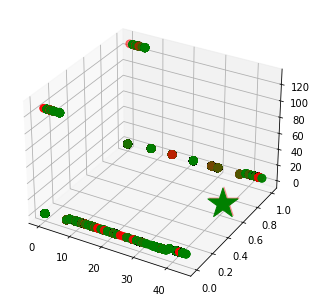

In [9]:
plot_3d(X, kmeans.cluster_centers_, labels)

In [73]:
df_labels = pd.DataFrame(labels, columns=["labels"])
df_labels.head()
df_transformed_copy = df_transformed.copy().reset_index(drop=True)
df_transformed_labeled = df_transformed_copy.join(df_labels["labels"])
df_transformed_labeled.head()

,application_name,direction,engine_id,wan_ip_country_code,l4_proto,selector_name,tcp_flags,tos,wan_interface_name,wan_ip,wan_ip_as_name,wan_l4_port,events,hour,sum_bytes_hourly_mean,sum_bytes_hourly_min,sum_bytes_hourly_max,sum_bytes_hourly_std,labels
0,43,1,6,77,1,4,0,192,1,2865,63,771,1,12,37696.668467,264191903,30,1.219509e+06,1
1,43,1,6,77,17,4,0,0,1,2883,19,54606,1,12,37696.668467,264191903,30,1.219509e+06,1
2,43,1,6,77,17,4,0,0,1,2882,255,60733,1,12,37696.668467,264191903,30,1.219509e+06,1
3,43,1,6,77,17,4,0,0,1,2889,59,58244,1,12,37696.668467,264191903,30,1.219509e+06,1
4,43,1,6,77,17,4,0,0,1,2896,315,65504,1,12,37696.668467,264191903,30,1.219509e+06,1


In [76]:
label_grouped = df_transformed_labeled.groupby(['labels'])

print(label_grouped['labels'].value_counts())

df_considered_normal = label_grouped.get_group(1)
df_considered_anomaly = label_grouped.get_group(0)


labels  labels
0       0          770598
1       1         2565738
Name: labels, dtype: int64


In [77]:
df_considered_normal.drop("labels", axis=1, inplace=True)
df_considered_normal.to_csv(mainpath+"considered_normal.csv", encoding='utf-8', index=False)

C:\Users\vielm\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [79]:
df_considered_anomaly.drop("labels", axis=1, inplace=True)
df_considered_anomaly.to_csv(mainpath + "considered_anomaly.csv", encoding='utf-8', index=False)

C:\Users\vielm\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [80]:
asdasd = pd.read_csv(mainpath + "considered_anomaly.csv")
asdasd.head()

,application_name,direction,engine_id,wan_ip_country_code,l4_proto,selector_name,tcp_flags,tos,wan_interface_name,wan_ip,wan_ip_as_name,wan_l4_port,events,hour,sum_bytes_hourly_mean,sum_bytes_hourly_min,sum_bytes_hourly_max,sum_bytes_hourly_std
0,43,1,6,77,6,4,15,0,1,2891,847,42010,1,13,57576.974084,1424583596,30,4.763674e+06
1,43,1,6,18,17,4,0,0,1,2892,24,58876,1,13,57576.974084,1424583596,30,4.763674e+06
2,43,1,6,77,6,4,6,0,1,1592,456,56426,1,13,57576.974084,1424583596,30,4.763674e+06
3,43,1,6,77,6,4,4,0,1,2861,59,443,1,13,57576.974084,1424583596,30,4.763674e+06
4,43,1,6,77,6,4,4,0,1,2861,59,443,1,13,57576.974084,1424583596,30,4.763674e+06
